In [1]:
global ROOT_DIR
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase'
global DATA_DIR
DATA_DIR = f'{ROOT_DIR}/data/IXITiny'

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
import json
sys.path.append(f'{ROOT_DIR}/code/helper/')
import OTCost as ot
import importlib
importlib.reload(ot)
import torch
sys.path.append(f'{ROOT_DIR}/code/IXITiny/')
import embedding as embed
import importlib
importlib.reload(embed)
from unet import UNet
import torch.nn.functional as F
import torch.nn as nn

# Embed Images

In [34]:
n_emb = 1024
BATCH_SIZE = 1

## Load Data

In [15]:
train_loader, val_loader = embed.load_data()

## Check losses

In [124]:
with open(f'{ROOT_DIR}/data/IXITiny/losses.json', 'r') as f:
        losses = json.load(f)

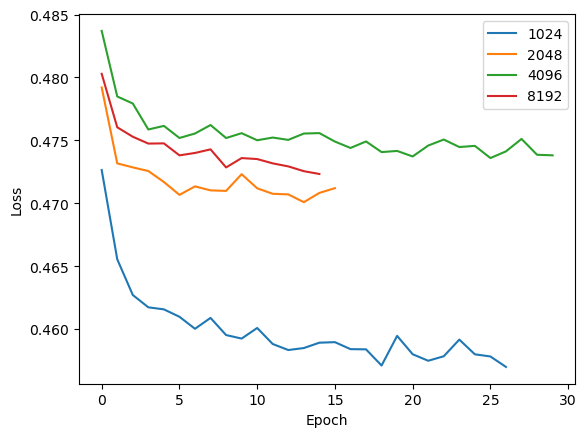

In [122]:
#Plot validation losses (100 and 500 were checkpointed)
for key, value in losses.items():
    label = key
    loss_list = value[0]
    plt.plot(loss_list, label=label)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Load model

In [35]:
model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    )
checkpoint = torch.load(f'{ROOT_DIR}/data/IXITiny/whole_images_epoch_5.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['weights'])
ae = embed.Autoencoder(n_emb)
if f'model_checkpoint_{n_emb}.pth' in os.listdir(f'{DATA_DIR}/'):
    state_dict = torch.load(f'{DATA_DIR}/model_checkpoint_{n_emb}.pth', map_location=torch.device('cpu'))
    ae.load_state_dict(state_dict)
    ae.eval()

In [9]:
def model_run(model, ae, image):
    CHANNELS_DIMENSION = 1
    with torch.no_grad():
        skip_connections, encoding = model.encoder(image)
        encoding = model.bottom_block(encoding)
        ### WITHOUT AE
        x = model.decoder(skip_connections, encoding)
        logits = model.classifier(x)
        
        ### WITH AE
        encoding_ = ae(encoding, embedding=False)
        x_ae = model.decoder(skip_connections, encoding_)
        logits_ae = model.classifier(x_ae)

    probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
    probabilities_ae = F.softmax(logits_ae, dim=CHANNELS_DIMENSION)

    return probabilities, probabilities_ae

## Visualise

In [10]:
def visualize(images, reconstructed_images, n=8):
    for i in range(n):# Selecting a specific slice index
        slice_idx = 21

        # Getting the 2D slices
        slice_img1 = images[i, 0, slice_idx, :, :]
        slice_img2 = reconstructed_images[i, 0, slice_idx, :, :]

        # Plotting the slices
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(slice_img1, cmap='gray')
        axes[0].set_title('Slice from Image 1')
        axes[1].imshow(slice_img2, cmap='gray')
        axes[1].set_title('Slice from Image 2')

    plt.show()

In [38]:
images = next(iter(train_loader))
image = images['mri']['data']
brain = images['brain']['data']

In [39]:
image_no, image_ae = model_run(model, ae, image)

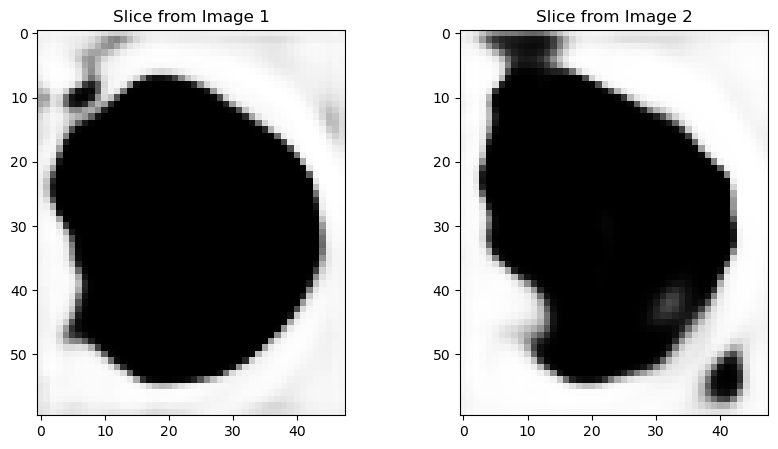

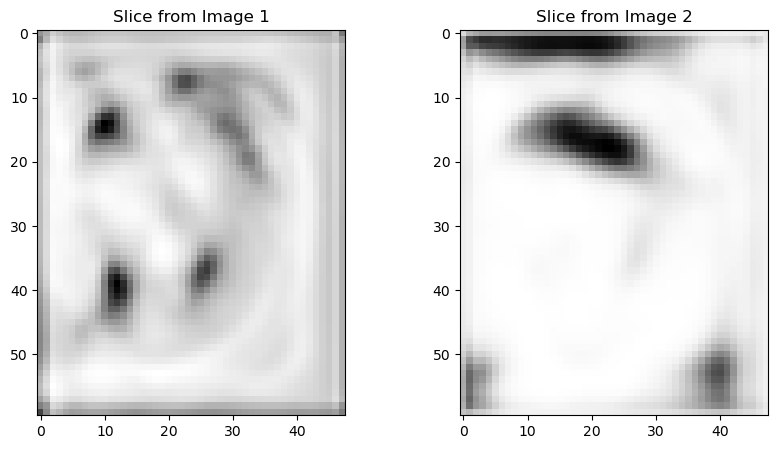

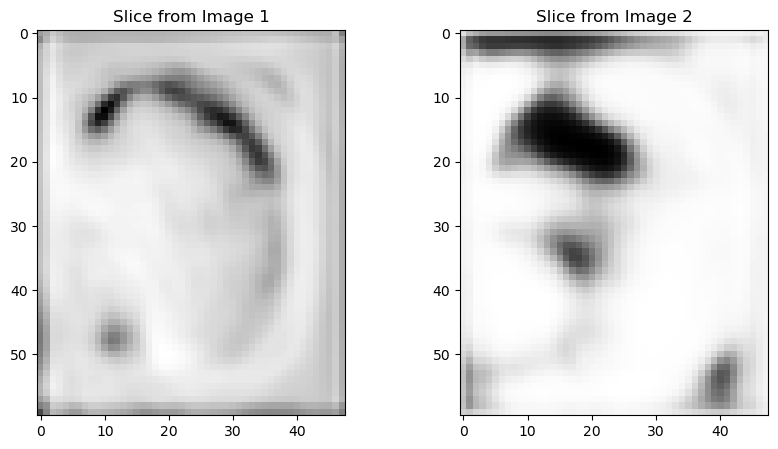

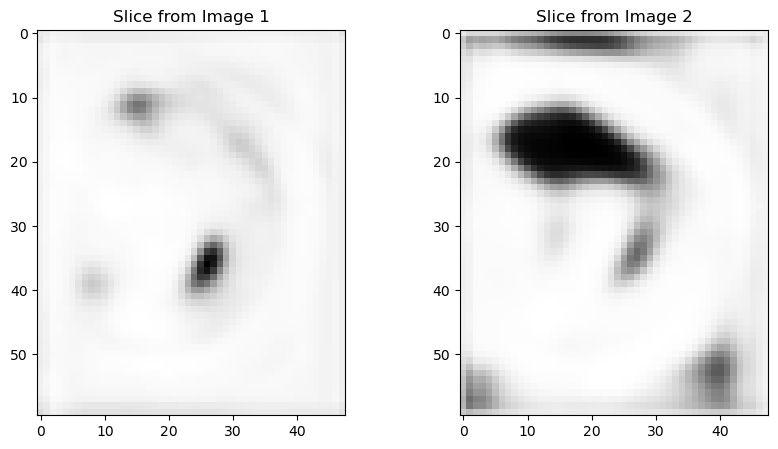

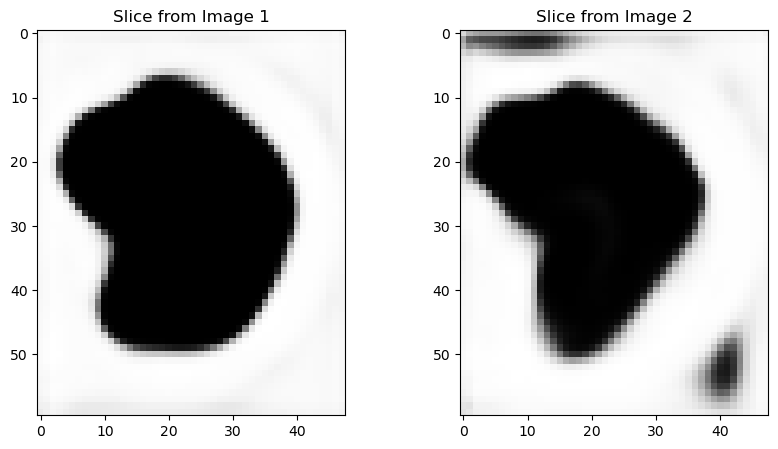

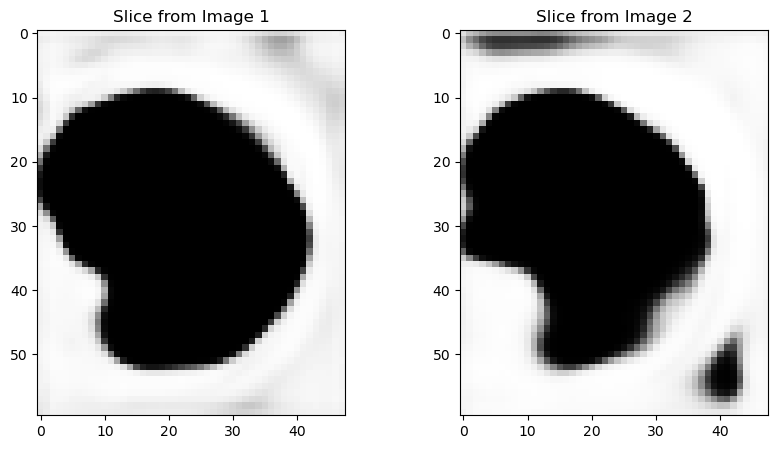

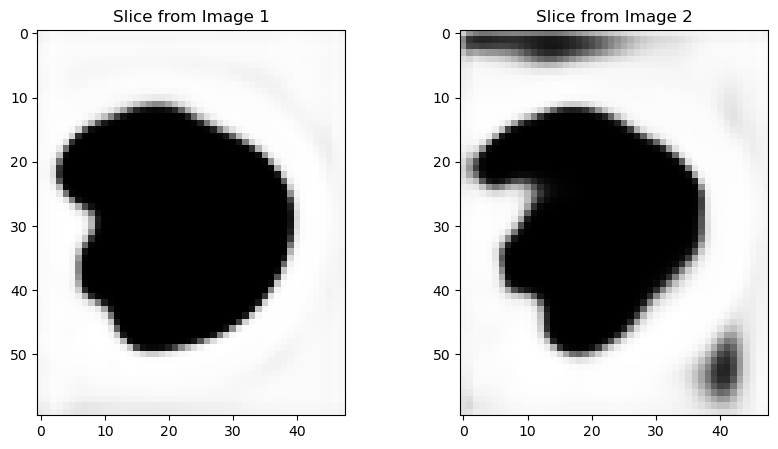

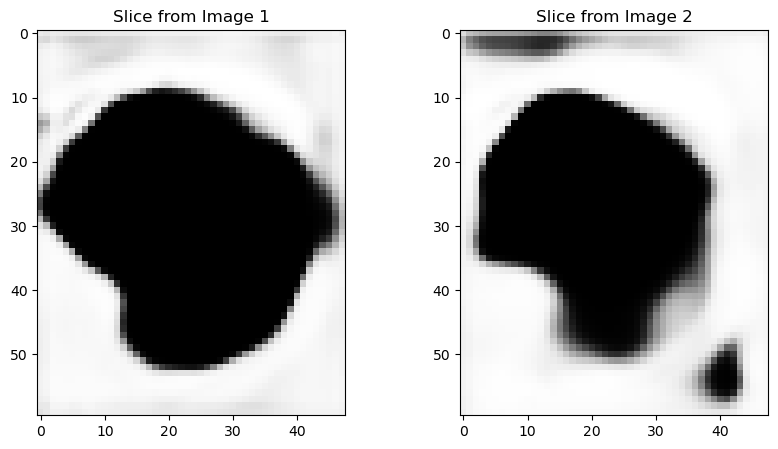

In [40]:
visualize(image_no, image_ae)

## Create embeddings for all images

In [41]:
def extract_embedding(image):
    with torch.no_grad():
        skip_connections, encoding = model.encoder(image)
        encoding = model.bottom_block(encoding)
        embedding = ae(encoding, embedding=True)
        return embedding

In [42]:
def create_embedding(loader):
    for image in loader:
        embedding = extract_embedding(image['mri']['data'].float())
        paths = image['mri']['path']
        emb_paths = [path.replace('image', 'embedding') for path in paths]
        emb_paths = [path.replace('.nii.gz', '') for path in emb_paths]
        for i in range(len(emb_paths)):
            emb_save = embedding[i].numpy()
            emb_path = emb_paths[i]
            np.save(emb_path, emb_save)
    return


In [43]:
create_embedding(train_loader)
create_embedding(val_loader)

## Create embedding datasets to calculate cost

In [44]:
files = os.listdir(f'{DATA_DIR}/embedding')
sites = ['Guys', 'HH', 'IOP']
site_samples = {}
site_embeddings = {}
for site in sites:
    site_samples[site] = [file for file in files if site in file]

for site, files in site_samples.items():
    embeddings = [np.load(f'{DATA_DIR}/embedding/{file}') for file in files]
    site_embeddings[site] = np.array(embeddings) 


## Measure OT cost

In [45]:
DATASET = 'IXITiny'

In [82]:
importlib.reload(ot)
X1, X2 = site_embeddings['Guys'][:], site_embeddings['HH'][:]
data = {'1': X1, '2': X2}
labels = {'1': np.ones(X1.shape[0]), '2': np.ones(X2.shape[0])}

IXITiny_OTCost_label = ot.OTCost(DATASET, data, labels)
cost = IXITiny_OTCost_label.calculate_ot_cost()
cost = "{:.2f}".format(float(cost))

cost: 0.08


In [86]:
importlib.reload(ot)
X1, X2 = site_embeddings['Guys'][:], site_embeddings['IOP'][:]
data = {'1': X1, '2': X2}
labels = {'1': np.ones(X1.shape[0]), '2': np.ones(X2.shape[0])}

IXITiny_OTCost_label = ot.OTCost(DATASET, data, labels)
cost = IXITiny_OTCost_label.calculate_ot_cost()
cost = "{:.2f}".format(float(cost))

cost: 0.28


In [120]:
importlib.reload(ot)
X1, X2 = site_embeddings['HH'][:], site_embeddings['IOP'][:]
data = {'1': X1, '2': X2}
labels = {'1': np.ones(X1.shape[0]), '2': np.ones(X2.shape[0])}

IXITiny_OTCost_label = ot.OTCost(DATASET, data, labels)
cost = IXITiny_OTCost_label.calculate_ot_cost()
cost = "{:.2f}".format(float(cost))

cost: 0.30


# Save image after UNET w/o classifier

In [397]:
# This step is allowed as we are 'freezing' all parameters until classification layer. 
# This speeds up compute

In [3]:
model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    )

class PreClassifierModel(nn.Module):
    def __init__(self, original_model):
        super(PreClassifierModel, self).__init__()
        
        self.encoder = original_model.encoder
        self.bottom_block = original_model.bottom_block
        self.decoder = original_model.decoder

    def forward(self, x):
        skip_connections, encoding = self.encoder(x)
        encoding = self.bottom_block(encoding)
        x = self.decoder(skip_connections, encoding)
        return x

In [4]:
pre_class_model = PreClassifierModel(model)
def create_pre_class_features(loader, pre_class_model):
    for image in loader:
        pre_class_rep = pre_class_model(image['mri']['data'].float())
        paths = image['mri']['path']
        pre_class_paths = [path.replace('image', 'representation') for path in paths]
        pre_class_paths = [path.replace('.nii.gz', '') for path in pre_class_paths]
        for i in range(len(pre_class_paths)):
            pre_class_save = pre_class_rep[i]
            pre_class_path = pre_class_paths[i]
            torch.save(pre_class_save, pre_class_path)
    return

In [445]:
create_pre_class_features(train_loader, pre_class_model )
create_pre_class_features(val_loader, pre_class_model )